# Introduction

In this notebook, we will visualize the uncertainty of a regression analysis by using a visualization technique called hypothetical outcome plots. The adopted regression method is the **Gaussian Process** approach, which is delivered by using the GP implementation from `Scikit-Learn`. 

# Hypothetical outcome plots

Hypothetical outcome plots (HOP) is an effective approach to communicate data uncertainty. This method visualizes uncertainty through animations by cycling through a number of different plots, each of which represents one possible outcome drawn from the outcome distribution.

In this notebook, we will create an animation of a series of possible regression curves drawn from the posterior distribution of the trained Gaussian Process model.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

### 1. Generate training data

In this step, we create some "noisy" training data. First of all, we generate clean data using the following test function:

\begin{equation}
f(x) = (6x-2)^2 sin(12x-4), \; x \in [0, 1]
\end{equation}

Later, we will "pollute" the clean data by adding random noise.

In [14]:
# Sample locations
X_train = np.array([[0,0.04,0.06,0.07,0.1,0.12,0.15,\
                     0.18,0.2,0.24,0.31,0.35,0.38,0.4,0.44,\
                     0.5,0.52,0.55,0.62,0.67,0.73,0.8,0.9,0.96,1]]).T
# Generate clean data
y_clean = (X_train*6-2)**2*np.sin(X_train*12-4)

# Generate noisy data
noise_std = 1
np.random.seed(42)
noise = np.random.normal(loc=0.0, scale=noise_std, size=(X_train.shape[0],1))
y_train = y_clean + noise

A visualization of the noisy training set is given below.

(-10.0, 20.0)

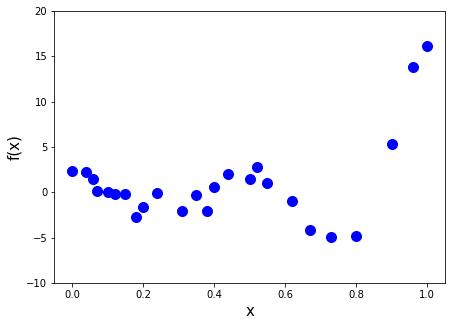

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])

### 2. Train GP model

In this step, we train a GP model based on the generated training dataset and display its prediction results.

In [42]:
# Train Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=0.4, 
                                    normalize_y=True)
model.fit(X_train, y_train)

# GP prediction
X_test = np.arange(0, 1.01, 0.01)
y_pred, pred_cov = model.predict(X_test.reshape((-1, 1)), return_cov=True)
y_pred = np.ravel(y_pred)

# Prediction standard deviation
pred_std = np.sqrt(np.diag(pred_cov))

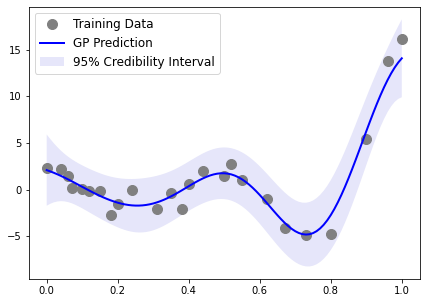

In [46]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_train,y_train,'o',color=(0.5,0.5,0.5),markerfacecolor=(0.5,0.5,0.5),markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.fill_between(X_test, y_pred-1.96*pred_std, y_pred+1.96*pred_std,facecolor='lavender',label='95% Credibility Interval')
# ax.plot(X_test,y_pred+1.95*pred_std,'b--',linewidth=1.5)
# ax.plot(X_test,y_pred-1.95*pred_std,'b--',linewidth=1.5,label='95% Credibility Interval')
# ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12});

In the above figure, a credibility interval is shown to display the uncertainty of the predictions of the trained GP model. This interval is calculated as $[\mu(x)-1.96\sigma(x), \mu(x)+1.96\sigma(x)]$, where $\mu(x)$ is the prediction mean and $\sigma(x)$ is the prediction standard deviation, at location $x$. 

Although this is a popular way to present model prediction uncertainty in academic research, for a broad audience, this static uncertainty visualization can be quite misleading:

1. 